# Proposal

## Aim:

To make prediction of SalePrice based on categorical data with past data as training set. Apply three models, multiple linear regression, decision tree, and random forest to make forecast.

## Primary Objective:

- To fill columns with na values

- Find outliers that may affect outcome

- Concatenate past training data with new test data

- To find the SalePrice of our new test set

## Secondary Objective:

- Find values other than 0 that can fill the missing columns to improve accuracy.

- Find better models, if so, that can improve accuracy

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
house = pd.read_csv('./train.csv', delimiter = ',')
test_data = pd.read_csv('./test.csv', delimiter = ',')

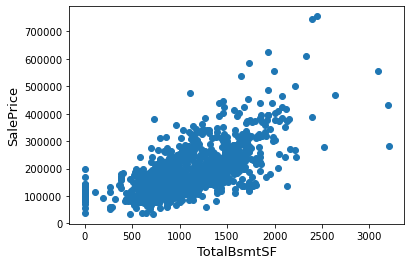

In [8]:
fig, ax = plt.subplots()
ax.scatter(x = house['TotalBsmtSF'], y = house['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

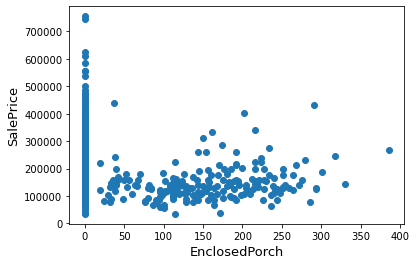

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = house['EnclosedPorch'], y = house['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('EnclosedPorch', fontsize=13)
plt.show()

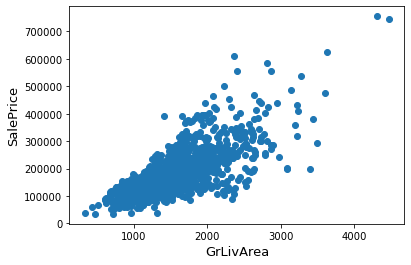

In [10]:
fig, ax = plt.subplots()
ax.scatter(x = house['GrLivArea'], y = house['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We are able to see that there are two outliers may affect our data when GrLivArea > 4000 and SalePrice < 300,000, therefore we will remove them.

In [11]:
house = house.drop(columns = ['Id'])
house = house.drop(house[(house['GrLivArea'] > 4000) & (house['SalePrice'] < 300000)].index)
house = house.drop(house[(house['TotalBsmtSF'] > 6000) & (house['SalePrice'] < 300000)].index)
house = house.drop(house[(house['EnclosedPorch'] > 500) & (house['SalePrice'] < 300000)].index)

house = house.fillna(0)
test_Id = test_data['Id']
test_data = test_data.drop(columns = ['Id'])
test_data = test_data.fillna(0)

y_train = house['SalePrice'].values
final_df = pd.concat((house, test_data)).reset_index(drop = True)
final_df = final_df.drop(columns = 'SalePrice')

KeyError: "['Id'] not found in axis"

In [12]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [13]:
final_test = []
for category in final_df:
    if pd.to_numeric(final_df[str(category)], errors='coerce').notnull().all() == False:
        final_test.append(str(category))

In [14]:
final_dummies = pd.get_dummies(final_df, columns = final_test)

In [15]:
final_dummies

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2912,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2913,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2914,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [16]:
labels = house[['SalePrice']]
print("check labels: ", labels.head(3))
labels.shape[0]

check labels:     SalePrice
0     208500
1     181500
2     223500


1457

In [17]:
features = final_dummies.reset_index(drop = True)

In [18]:
features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2912,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2913,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2914,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [19]:
X = features[:labels.shape[0]]
y = labels

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.05,random_state=0)

print("number of training samples: ", len(X_train))
print("number of test samples:", len(y_test))

number of training samples:  1384
number of test samples: 73


In [20]:
mlr = LinearRegression()
mlr.fit(X_train,y_train)
mlr_score = mlr.score(X_test,y_test)
pred_mlr = mlr.predict(X_test)
expl_mlr = explained_variance_score(pred_mlr,y_test)

In [21]:
pred_mlr

array([[306413.2295057 ],
       [252802.89233983],
       [319426.04678268],
       [287610.43465243],
       [288532.83442625],
       [117952.02656564],
       [102532.63757639],
       [213971.45463431],
       [229721.51491693],
       [262282.14065919],
       [ 44798.35904478],
       [196886.67285099],
       [112869.72230414],
       [143974.09365015],
       [106489.33531894],
       [ 97812.51068261],
       [224498.31871822],
       [ 58280.96531243],
       [130722.2336929 ],
       [145178.10311579],
       [312371.89783817],
       [308702.97496546],
       [ 90835.00640191],
       [106997.66238633],
       [431117.32138001],
       [247522.90955224],
       [ 93245.03458866],
       [107816.71556897],
       [151039.96784558],
       [245739.65333723],
       [173990.28362269],
       [237755.18277736],
       [143005.81753557],
       [194872.4316927 ],
       [106578.85638192],
       [160618.36090649],
       [107707.69493615],
       [168915.91806519],
       [2446

In [22]:
y_test

,SalePrice
412,222000
212,252678
343,266000
304,295000
159,320000
...,...
860,189950
846,213000
1191,174000
530,175000


In [23]:
from sklearn.tree import DecisionTreeRegressor
tr_regressor = DecisionTreeRegressor(random_state=0)
tr_regressor.fit(X_train,y_train)
tr_regressor.score(X_test,y_test)
pred_tr = tr_regressor.predict(X_test)
decision_score=tr_regressor.score(X_test,y_test)
expl_tr = explained_variance_score(pred_tr,y_test)

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=28,random_state=0)
rf_regressor.fit(X_train,y_train)
rf_regressor.score(X_test,y_test)
rf_pred =rf_regressor.predict(X_test)
rf_score=rf_regressor.score(X_test,y_test)
expl_rf = explained_variance_score(rf_pred,y_test)

In [25]:
print("Multiple Linear Regression Model Score is ",round(mlr.score(X_test,y_test)*100))
print("Decision tree  Regression Model Score is ",round(tr_regressor.score(X_test,y_test)*100))
print("Random Forest Regression Model Score is ",round(rf_regressor.score(X_test,y_test)*100))

#Let's have a tabular pandas data frame, for a clear comparison

models_score =pd.DataFrame({'Model':['Multiple Linear Regression','Decision Tree','Random forest Regression'],
                            'Score':[mlr_score,decision_score,rf_score],
                            'Explained Variance Score':[expl_mlr,expl_tr,expl_rf]
                           })
models_score.sort_values(by='Score',ascending=False)

Multiple Linear Regression Model Score is  90
Decision tree  Regression Model Score is  72
Random Forest Regression Model Score is  90


,Model,Score,Explained Variance Score
2,Random forest Regression,0.899900,0.905615
0,Multiple Linear Regression,0.895156,0.917049
1,Decision Tree,0.722635,0.788302


In [26]:
prediction_df = pd.DataFrame(rf_regressor.predict(features[labels.shape[0]:]), columns = ['SalePrice'])
prediction_df['Id'] = test_Id
prediction_df.head()

,SalePrice,Id
0,130376.785714,1461
1,152969.642857,1462
2,175403.571429,1463
3,177947.571429,1464
4,203892.857143,1465


In [27]:
prediction_df.to_csv("my_predictions.csv", index = False)